In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from compute_benchmarks import *
import time

Found 2 devices
device 0: (null) (null) EGL_EXT_device_drm EGL_EXT_device_drm_render_node
device 1: (null) (null) EGL_MESA_device_software EGL_EXT_device_drm_render_node
eglInitialize: 1.4
egl 1.4, GLES 3.1
Panfrost Mali-G52 (Panfrost) OpenGL ES 3.1 Mesa 22.2.0


## Test 1: 16 FMAs per invocation (2 vec4 loads + 1 vec4 store)

In [ ]:
def test(wh=None, w=1024, h=1024, localsz=None, localx=1, localy=1, unrollx=1, unrolly=1):
    global intex, outtex, source
    if wh is not None:
        w,h = wh,wh
    if localsz is not None:
        localx, localy = localsz
    src = np.stack([np.stack([np.full(w*2, 1, dtype=np.uint8)]*4, axis=-1)]*h).astype(np.float32)
    intex = createTexture(w*2, h, fmt=gl.GL_RGBA32F, output=False, src=src)
    outtex = createTexture(w, h, texid=1, fmt=gl.GL_RGBA32F)
    source = f"""
    #version 310 es
    precision mediump float;

    layout(local_size_x = {localx}, local_size_y = {localy}) in;
    layout(rgba32f, binding = 0) uniform mediump readonly image2D img_input;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;

    void main() {{
      ivec2 start_coords = ivec2(gl_GlobalInvocationID.xy) * ivec2(2,{unrolly});
      highp vec4 x, y;
      x = imageLoad(img_input, start_coords + ivec2(0,0));
      y = imageLoad(img_input, start_coords + ivec2(1,0));
      highp vec4 r = vec4(
          dot(x.xyzw, y.xyzw),
          dot(x.xyzw, y.yxwz),
          dot(x.xyzw, y.zwxy),
          dot(x.xyzw, y.wzyx)
      );
      imageStore(img_output, ivec2(gl_GlobalInvocationID.xy), r);
    }}
    """
    computeShader(source)
    start = time.perf_counter()
    for i in range(50):
        gl.glDispatchCompute(w//localx, h//unrolly//localy, 1)
        # make sure writing to image has finished before read
        gl.glMemoryBarrier(gl.GL_SHADER_IMAGE_ACCESS_BARRIER_BIT)
    gl.glFinish()
    elapsed = (time.perf_counter() - start)/50
    output = downloadTextureFloat(outtex, w, h)
    MACs = output.sum()
#     print(MACs, elapsed, w*h*2*4*4)
    gflops, mem_mbps = MACs / elapsed / 1e9, w*h*2*4*4 / elapsed / 1024 / 1024
    return gflops

gflops = test(localy=8)
print(source)
print(gflops)
showLastShaderDisassembly()


    #version 310 es
    precision mediump float;

    layout(local_size_x = 1, local_size_y = 8) in;
    layout(rgba32f, binding = 0) uniform mediump readonly image2D img_input;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;

    void main() {
      ivec2 start_coords = ivec2(gl_GlobalInvocationID.xy) * ivec2(2,1);
      highp vec4 x, y;
      x = imageLoad(img_input, start_coords + ivec2(0,0));
      y = imageLoad(img_input, start_coords + ivec2(1,0));
      highp vec4 r = vec4(
          dot(x.xyzw, y.xyzw),
          dot(x.xyzw, y.yxwz),
          dot(x.xyzw, y.zwxy),
          dot(x.xyzw, y.wzyx)
      );
      imageStore(img_output, ivec2(gl_GlobalInvocationID.xy), r);
    }
    
1.2023323586109347
FMAs: 64.00% (16 / 25)

clause_0:
ds(0) nbb attr ncph next_attr dwb(0) 
{
    *LSHIFT_OR.i32 r0:t0, r60, #0, 0x00000001 /* 0.000000 */
    +NOP t1
    *MKVEC.v2i16 t0, t0, r61
    +LD_ATTR_TEX.f32.v4 t1, t, #0.x, #0.x, @r1
}

clause_3:
ds(0) nbb attr ncp

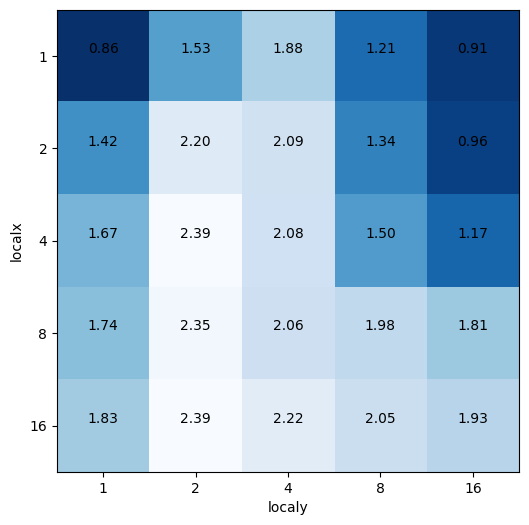

In [ ]:
r = grid_run(test, localx=[1,2,4,8,16], localy=[1,2,4,8,16])
grid_show(r, colorfun=lambda x: -x)

## Test 2: 48 FMAs per invocation (3 vec4 loads + 1 vec4 store)

In [ ]:
def test(wh=None, w=1024, h=1024, localsz=None, localx=1, localy=1, unrollx=1, unrolly=1, membw=False):
    global intex, outtex, source
    if wh is not None:
        w,h = wh,wh
    if localsz is not None:
        localx, localy = localsz
    src = np.stack([np.stack([np.full(w*3, 1, dtype=np.uint8)]*4, axis=-1)]*h).astype(np.float32)
    intex = createTexture(w*3, h, fmt=gl.GL_RGBA32F, output=False, src=src)
    outtex = createTexture(w, h, texid=1, fmt=gl.GL_RGBA32F)
    source = f"""
    #version 310 es
    precision mediump float;

    layout(local_size_x = {localx}, local_size_y = {localy}) in;
    layout(rgba32f, binding = 0) uniform mediump readonly image2D img_input;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;

    void main() {{
      ivec2 start_coords = ivec2(gl_GlobalInvocationID.xy) * ivec2(3,{unrolly});
      highp vec4 x, y, z;
      x = imageLoad(img_input, start_coords + ivec2(0,0));
      y = imageLoad(img_input, start_coords + ivec2(1,0));
      z = imageLoad(img_input, start_coords + ivec2(2,0));
      highp vec4 r0 = vec4(
          dot(x.xyzw, y.xyzw),
          dot(x.xyzw, y.yxwz),
          dot(x.xyzw, y.zwxy),
          dot(x.xyzw, y.wzyx)
      );
      highp vec4 r1 = vec4(
          dot(x.xyzw, z.xyzw),
          dot(x.xyzw, z.yxwz),
          dot(x.xyzw, z.zwxy),
          dot(x.xyzw, z.wzyx)
      );
      highp vec4 r2 = vec4(
          dot(y.xyzw, z.xyzw),
          dot(y.xyzw, z.yxwz),
          dot(y.xyzw, z.zwxy),
          dot(y.xyzw, z.wzyx)
      );
      imageStore(img_output, ivec2(gl_GlobalInvocationID.xy), r0 + r1 + r2);
    }}
    """
    computeShader(source)
    start = time.perf_counter()
    for i in range(50):
        gl.glDispatchCompute(w//localx, h//unrolly//localy, 1)
        # make sure writing to image has finished before read
        gl.glMemoryBarrier(gl.GL_SHADER_IMAGE_ACCESS_BARRIER_BIT)
    gl.glFinish()
    elapsed = (time.perf_counter() - start)/50
    output = downloadTextureFloat(outtex, w*3, h)
    MACs = output.sum()
#     print(MACs, elapsed, 4*w*h*4*4)
    if membw:
        return MACs / elapsed / 1e9, 4*w*h*4*4 / elapsed / 1024 / 1024
    else:
        return MACs / elapsed / 1e9

# test(localsz=(1,1), unrollx=4, unrolly=4)
test()
test()
gflops = test(localx=8, localy=2, membw=True)
print(source)
print(gflops)
showLastShaderDisassembly()


    #version 310 es
    precision mediump float;

    layout(local_size_x = 8, local_size_y = 2) in;
    layout(rgba32f, binding = 0) uniform mediump readonly image2D img_input;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;

    void main() {
      ivec2 start_coords = ivec2(gl_GlobalInvocationID.xy) * ivec2(3,1);
      highp vec4 x, y, z;
      x = imageLoad(img_input, start_coords + ivec2(0,0));
      y = imageLoad(img_input, start_coords + ivec2(1,0));
      z = imageLoad(img_input, start_coords + ivec2(2,0));
      highp vec4 r0 = vec4(
          dot(x.xyzw, y.xyzw),
          dot(x.xyzw, y.yxwz),
          dot(x.xyzw, y.zwxy),
          dot(x.xyzw, y.wzyx)
      );
      highp vec4 r1 = vec4(
          dot(x.xyzw, z.xyzw),
          dot(x.xyzw, z.yxwz),
          dot(x.xyzw, z.zwxy),
          dot(x.xyzw, z.wzyx)
      );
      highp vec4 r2 = vec4(
          dot(y.xyzw, z.xyzw),
          dot(y.xyzw, z.yxwz),
          dot(y.xyzw, z.zwxy),
      

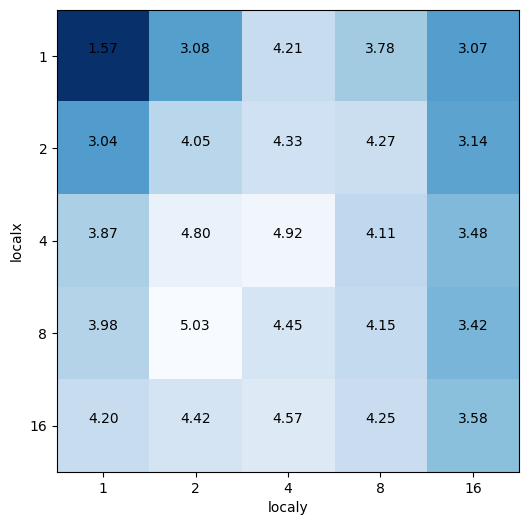

In [ ]:
r = grid_run(test, localx=[1,2,4,8,16], localy=[1,2,4,8,16])
grid_show(r, colorfun=lambda x: -x)

## Test 3: 107 FMAs per invocation (3 vec4 loads + 1 vec4 store)

Watch out since it's doing only 107 multiplications and not 112 as might be naively counted. This means the reported GFLOPS number needs to be corrected manually.

In [ ]:
def test(wh=None, w=1024, h=1024, localsz=None, localx=1, localy=1, unrollx=1, unrolly=1, membw=False):
    global intex, outtex, source
    if wh is not None:
        w,h = wh,wh
    if localsz is not None:
        localx, localy = localsz
    src = np.stack([np.stack([np.full(w*3, 1, dtype=np.uint8)]*4, axis=-1)]*h).astype(np.float32)
    intex = createTexture(w*3, h, fmt=gl.GL_RGBA32F, output=False, src=src)
    outtex = createTexture(w, h, texid=1, fmt=gl.GL_RGBA32F)
    source = f"""
    #version 310 es
    precision mediump float;

    layout(local_size_x = {localx}, local_size_y = {localy}) in;
    layout(rgba32f, binding = 0) uniform mediump readonly image2D img_input;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;

    void main() {{
      ivec2 start_coords = ivec2(gl_GlobalInvocationID.xy) * ivec2(3,{unrolly});
      highp vec4 x, y, z;
      x = imageLoad(img_input, start_coords + ivec2(0,0));
      y = imageLoad(img_input, start_coords + ivec2(1,0));
      z = imageLoad(img_input, start_coords + ivec2(2,0));
      highp vec4 r0 = vec4(
          dot(x.xyzw, y.xyzw),
          dot(x.xyzw, y.yxwz),
          dot(x.xyzw, y.zwxy),
          dot(x.xyzw, y.wzyx)
      );
      highp vec4 r1 = vec4(
          dot(x.xyzw, z.xyzw),
          dot(x.xyzw, z.yxwz),
          dot(x.xyzw, z.zwxy),
          dot(x.xyzw, z.wzyx)
      );
      highp vec4 r2 = vec4(
          dot(y.xyzw, z.xyzw),
          dot(y.xyzw, z.yxwz),
          dot(y.xyzw, z.zwxy),
          dot(y.xyzw, z.wzyx)
      );
      highp vec4 r3 = vec4(
          dot(r0.xyzw, z.xyzw) / 4.,
          dot(r0.xyzw, z.yxwz) / 4.,
          dot(r0.xyzw, z.zwxy) / 4.,
          dot(r0.xyzw, z.wzyx) / 4.
      );
      highp vec4 s0 = vec4(
          dot(x.xyzw, x.xyzw),
          dot(x.xyzw, x.yxwz),
          dot(x.xyzw, x.zwxy),
          dot(x.xyzw, x.wzyx)
      );
      highp vec4 s1 = vec4(
          dot(y.xyzw, y.xyzw),
          dot(y.xyzw, y.yxwz),
          dot(y.xyzw, y.zwxy),
          dot(y.xyzw, y.wzyx)
      );
      highp vec4 s2 = vec4(
          dot(z.xyzw, z.xyzw),
          dot(z.xyzw, z.yxwz),
          dot(z.xyzw, z.zwxy),
          dot(z.xyzw, z.wzyx)
      );
      r0.x -= 5.; // optimizer correction
      imageStore(img_output, ivec2(gl_GlobalInvocationID.xy), r0 + r1 + r2 + r3 + s0 + s1 + s2);
    }}
    """
    computeShader(source)
    start = time.perf_counter()
    for i in range(50):
        gl.glDispatchCompute(w//localx, h//unrolly//localy, 1)
        # make sure writing to image has finished before read
        gl.glMemoryBarrier(gl.GL_SHADER_IMAGE_ACCESS_BARRIER_BIT)
    gl.glFinish()
    elapsed = (time.perf_counter() - start)/50
    output = downloadTextureFloat(outtex, w*3, h)
#     assert(output[0,0,0] == reps * 4 * 4)
    MACs = output.sum()
#     print(wh, unrollx, elapsed)
#     print(MACs, elapsed, 4*w*h*4*4)

    if membw:
        print(output[0,0].sum())
        return MACs / elapsed / 1e9, 4*w*h*4*4 / elapsed / 1024 / 1024
    else:
        return MACs / elapsed / 1e9

# test(localsz=(1,1), unrollx=4, unrolly=4)
test()
test()
gflops = test(localx=8, localy=2, membw=True)
print(source)
print(gflops)
showLastShaderDisassembly()

107.0

    #version 310 es
    precision mediump float;

    layout(local_size_x = 8, local_size_y = 2) in;
    layout(rgba32f, binding = 0) uniform mediump readonly image2D img_input;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;

    void main() {
      ivec2 start_coords = ivec2(gl_GlobalInvocationID.xy) * ivec2(3,1);
      highp vec4 x, y, z;
      x = imageLoad(img_input, start_coords + ivec2(0,0));
      y = imageLoad(img_input, start_coords + ivec2(1,0));
      z = imageLoad(img_input, start_coords + ivec2(2,0));
      highp vec4 r0 = vec4(
          dot(x.xyzw, y.xyzw),
          dot(x.xyzw, y.yxwz),
          dot(x.xyzw, y.zwxy),
          dot(x.xyzw, y.wzyx)
      );
      highp vec4 r1 = vec4(
          dot(x.xyzw, z.xyzw),
          dot(x.xyzw, z.yxwz),
          dot(x.xyzw, z.zwxy),
          dot(x.xyzw, z.wzyx)
      );
      highp vec4 r2 = vec4(
          dot(y.xyzw, z.xyzw),
          dot(y.xyzw, z.yxwz),
          dot(y.xyzw, z.zwxy),


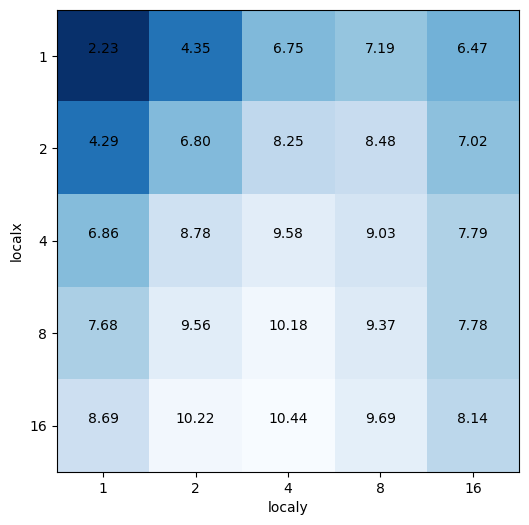

In [ ]:
r = grid_run(test, localx=[1,2,4,8,16], localy=[1,2,4,8,16])
grid_show(r, colorfun=lambda x: -x)

## Test 4: 169 FMAs per invocation (3 vec4 loads + 1 vec4 store)

In [ ]:
def test(wh=None, w=1024, h=1024, localsz=None, localx=1, localy=1, unrollx=1, unrolly=1, membw=False):
    global intex, outtex, source
    if wh is not None:
        w,h = wh,wh
    if localsz is not None:
        localx, localy = localsz
    src = np.stack([np.stack([np.full(w*3, 1, dtype=np.uint8)]*4, axis=-1)]*h).astype(np.float32)
    intex = createTexture(w*3, h, fmt=gl.GL_RGBA32F, output=False, src=src)
    outtex = createTexture(w, h, texid=1, fmt=gl.GL_RGBA32F)
    source = f"""
    #version 310 es
    precision mediump float;

    layout(local_size_x = {localx}, local_size_y = {localy}) in;
    layout(rgba32f, binding = 0) uniform mediump readonly image2D img_input;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;

    void main() {{
      ivec2 start_coords = ivec2(gl_GlobalInvocationID.xy) * ivec2(3,{unrolly});
      highp vec4 x, y, z;
      x = imageLoad(img_input, start_coords + ivec2(0,0));
      y = imageLoad(img_input, start_coords + ivec2(1,0));
      z = imageLoad(img_input, start_coords + ivec2(2,0));
      highp vec4 r0 = vec4(
          dot(x.xyzw, y.xyzw),
          dot(x.xyzw, y.yxwz),
          dot(x.xyzw, y.zwxy),
          dot(x.xyzw, y.wzyx)
      );
      highp vec4 r1 = vec4(
          dot(x.xyzw, z.xyzw),
          dot(x.xyzw, z.yxwz),
          dot(x.xyzw, z.zwxy),
          dot(x.xyzw, z.wzyx)
      );
      highp vec4 r2 = vec4(
          dot(y.xyzw, z.xyzw),
          dot(y.xyzw, z.yxwz),
          dot(y.xyzw, z.zwxy),
          dot(y.xyzw, z.wzyx)
      );
      highp vec4 r3 = vec4(
          dot(r0.xyzw, z.xyzw) / 4.,
          dot(r0.xyzw, z.yxwz) / 4.,
          dot(r0.xyzw, z.zwxy) / 4.,
          dot(r0.xyzw, z.wzyx) / 4.
      );
      highp vec4 s0 = vec4(
          dot(x.xyzw, x.xyzw),
          dot(x.xyzw, x.yxwz),
          dot(x.xyzw, x.zwxy),
          dot(x.xyzw, x.wzyx)
      );
      highp vec4 s1 = vec4(
          dot(y.xyzw, y.xyzw),
          dot(y.xyzw, y.yxwz),
          dot(y.xyzw, y.zwxy),
          dot(y.xyzw, y.wzyx)
      );
      highp vec4 s2 = vec4(
          dot(z.xyzw, z.xyzw),
          dot(z.xyzw, z.yxwz),
          dot(z.xyzw, z.zwxy),
          dot(z.xyzw, z.wzyx)
      );
      highp vec4 c0 = vec4(
          dot(s0.xyzw, x.xyzw) / 4.,
          dot(s0.xyzw, x.yxwz) / 4.,
          dot(s0.xyzw, x.zwxy) / 4.,
          dot(s0.xyzw, x.wzyx) / 4.
      );
      highp vec4 c1 = vec4(
          dot(s1.xyzw, y.xyzw) / 4.,
          dot(s1.xyzw, y.yxwz) / 4.,
          dot(s1.xyzw, y.zwxy) / 4.,
          dot(s1.xyzw, y.wzyx) / 4.
      );
      highp vec4 c2 = vec4(
          dot(s2.xyzw, z.xyzw) / 4.,
          dot(s2.xyzw, z.yxwz) / 4.,
          dot(s2.xyzw, z.zwxy) / 4.,
          dot(s2.xyzw, z.wzyx) / 4.
      );
      r0.x += 9.; // optimizer correction
      imageStore(img_output, ivec2(gl_GlobalInvocationID.xy), r0 + r1 + r2 + r3 + s0 + s1 + s2 + c0 + c1 + c2);
    }}
    """
    computeShader(source)
    start = time.perf_counter()
    for i in range(50):
        gl.glDispatchCompute(w//localx, h//unrolly//localy, 1)
        # make sure writing to image has finished before read
        gl.glMemoryBarrier(gl.GL_SHADER_IMAGE_ACCESS_BARRIER_BIT)
    gl.glFinish()
    elapsed = (time.perf_counter() - start)/50
    output = downloadTextureFloat(outtex, w*3, h)
#     assert(output[0,0,0] == reps * 4 * 4)
    MACs = output.sum()
#     print(wh, unrollx, elapsed)
#     print(MACs, elapsed, 4*w*h*4*4)

    if membw:
        print(output[0,0].sum())
        return MACs / elapsed / 1e9, 4*w*h*4*4 / elapsed / 1024 / 1024
    else:
        return MACs / elapsed / 1e9

# test(localsz=(1,1), unrollx=4, unrolly=4)
test()
test()
gflops = test(localx=8, localy=2, membw=True)
print(source)
print(gflops)
showLastShaderDisassembly()

169.0

    #version 310 es
    precision mediump float;

    layout(local_size_x = 8, local_size_y = 2) in;
    layout(rgba32f, binding = 0) uniform mediump readonly image2D img_input;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;

    void main() {
      ivec2 start_coords = ivec2(gl_GlobalInvocationID.xy) * ivec2(3,1);
      highp vec4 x, y, z;
      x = imageLoad(img_input, start_coords + ivec2(0,0));
      y = imageLoad(img_input, start_coords + ivec2(1,0));
      z = imageLoad(img_input, start_coords + ivec2(2,0));
      highp vec4 r0 = vec4(
          dot(x.xyzw, y.xyzw),
          dot(x.xyzw, y.yxwz),
          dot(x.xyzw, y.zwxy),
          dot(x.xyzw, y.wzyx)
      );
      highp vec4 r1 = vec4(
          dot(x.xyzw, z.xyzw),
          dot(x.xyzw, z.yxwz),
          dot(x.xyzw, z.zwxy),
          dot(x.xyzw, z.wzyx)
      );
      highp vec4 r2 = vec4(
          dot(y.xyzw, z.xyzw),
          dot(y.xyzw, z.yxwz),
          dot(y.xyzw, z.zwxy),


ndecode.dump.0278
pandecode: dump command stream to file pandecode.dump.0279
pandecode: dump command stream to file pandecode.dump.0280
pandecode: dump command stream to file pandecode.dump.0281
pandecode: dump command stream to file pandecode.dump.0282
pandecode: dump command stream to file pandecode.dump.0283
pandecode: dump command stream to file pandecode.dump.0284
pandecode: dump command stream to file pandecode.dump.0285
pandecode: dump command stream to file pandecode.dump.0286
pandecode: dump command stream to file pandecode.dump.0287
pandecode: dump command stream to file pandecode.dump.0288
pandecode: dump command stream to file pandecode.dump.0289
pandecode: dump command stream to file pandecode.dump.0290
pandecode: dump command stream to file pandecode.dump.0291
pandecode: dump command stream to file pandecode.dump.0292
pandecode: dump command stream to file pandecode.dump.0293
pandecode: dump command stream to file pandecode.dump.0294
pandecode: dump command stream to file

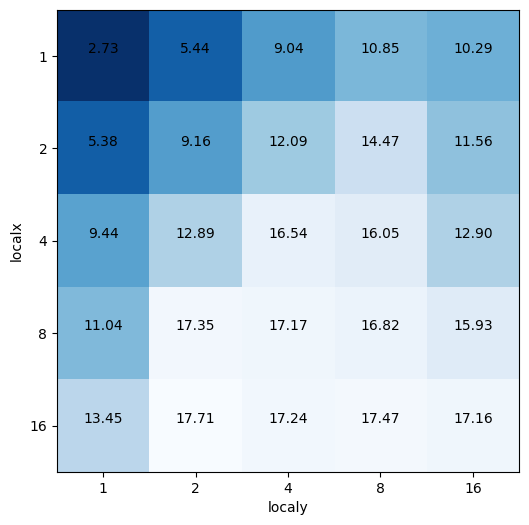

In [ ]:
r = grid_run(test, localx=[1,2,4,8,16], localy=[1,2,4,8,16])
grid_show(r, colorfun=lambda x: -x)

## Test 5: 169 FMAs per invocation (3 vec4 loads with overlap + 1 vec4 store)

In [ ]:
def test(wh=None, w=1024, h=1024, localsz=None, localx=1, localy=1, unrollx=1, unrolly=1, membw=False):
    global intex, outtex, source
    if wh is not None:
        w,h = wh,wh
    if localsz is not None:
        localx, localy = localsz
    src = np.stack([np.stack([np.full(w+2, 1, dtype=np.uint8)]*4, axis=-1)]*h).astype(np.float32)
    intex = createTexture(w+2, h, fmt=gl.GL_RGBA32F, output=False, src=src)
    outtex = createTexture(w, h, texid=1, fmt=gl.GL_RGBA32F)
    source = f"""
    #version 310 es
    precision mediump float;

    layout(local_size_x = {localx}, local_size_y = {localy}) in;
    layout(rgba32f, binding = 0) uniform mediump readonly image2D img_input;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;

    void main() {{
      ivec2 start_coords = ivec2(gl_GlobalInvocationID.xy) * ivec2(1,{unrolly});
      highp vec4 x, y, z;
      x = imageLoad(img_input, start_coords + ivec2(0,0));
      y = imageLoad(img_input, start_coords + ivec2(1,0));
      z = imageLoad(img_input, start_coords + ivec2(2,0));
      highp vec4 r0 = vec4(
          dot(x.xyzw, y.xyzw),
          dot(x.xyzw, y.yxwz),
          dot(x.xyzw, y.zwxy),
          dot(x.xyzw, y.wzyx)
      );
      highp vec4 r1 = vec4(
          dot(x.xyzw, z.xyzw),
          dot(x.xyzw, z.yxwz),
          dot(x.xyzw, z.zwxy),
          dot(x.xyzw, z.wzyx)
      );
      highp vec4 r2 = vec4(
          dot(y.xyzw, z.xyzw),
          dot(y.xyzw, z.yxwz),
          dot(y.xyzw, z.zwxy),
          dot(y.xyzw, z.wzyx)
      );
      highp vec4 r3 = vec4(
          dot(r0.xyzw, z.xyzw) / 4.,
          dot(r0.xyzw, z.yxwz) / 4.,
          dot(r0.xyzw, z.zwxy) / 4.,
          dot(r0.xyzw, z.wzyx) / 4.
      );
      highp vec4 s0 = vec4(
          dot(x.xyzw, x.xyzw),
          dot(x.xyzw, x.yxwz),
          dot(x.xyzw, x.zwxy),
          dot(x.xyzw, x.wzyx)
      );
      highp vec4 s1 = vec4(
          dot(y.xyzw, y.xyzw),
          dot(y.xyzw, y.yxwz),
          dot(y.xyzw, y.zwxy),
          dot(y.xyzw, y.wzyx)
      );
      highp vec4 s2 = vec4(
          dot(z.xyzw, z.xyzw),
          dot(z.xyzw, z.yxwz),
          dot(z.xyzw, z.zwxy),
          dot(z.xyzw, z.wzyx)
      );
      highp vec4 c0 = vec4(
          dot(s0.xyzw, x.xyzw) / 4.,
          dot(s0.xyzw, x.yxwz) / 4.,
          dot(s0.xyzw, x.zwxy) / 4.,
          dot(s0.xyzw, x.wzyx) / 4.
      );
      highp vec4 c1 = vec4(
          dot(s1.xyzw, y.xyzw) / 4.,
          dot(s1.xyzw, y.yxwz) / 4.,
          dot(s1.xyzw, y.zwxy) / 4.,
          dot(s1.xyzw, y.wzyx) / 4.
      );
      highp vec4 c2 = vec4(
          dot(s2.xyzw, z.xyzw) / 4.,
          dot(s2.xyzw, z.yxwz) / 4.,
          dot(s2.xyzw, z.zwxy) / 4.,
          dot(s2.xyzw, z.wzyx) / 4.
      );
      r0.x += 9.; // optimizer correction
      imageStore(img_output, ivec2(gl_GlobalInvocationID.xy), r0 + r1 + r2 + r3 + s0 + s1 + s2 + c0 + c1 + c2);
    }}
    """
    computeShader(source)
    start = time.perf_counter()
    for i in range(50):
        gl.glDispatchCompute(w//localx, h//unrolly//localy, 1)
        # make sure writing to image has finished before read
        gl.glMemoryBarrier(gl.GL_SHADER_IMAGE_ACCESS_BARRIER_BIT)
    gl.glFinish()
    elapsed = (time.perf_counter() - start)/50
    output = downloadTextureFloat(outtex, w, h)
#     assert(output[0,0,0] == reps * 4 * 4)
    MACs = output.sum()
#     print(wh, unrollx, elapsed)
#     print(MACs, elapsed, 4*w*h*4*4)

    if membw:
        print(output[0,0].sum())
        return MACs / elapsed / 1e9, 4*w*h*4*4 / elapsed / 1024 / 1024
    else:
        return MACs / elapsed / 1e9

# test(localsz=(1,1), unrollx=4, unrolly=4)
test()
test()
gflops = test(localx=16, localy=2, membw=True)
print(source)
print(gflops)
showLastShaderDisassembly()

169.0

    #version 310 es
    precision mediump float;

    layout(local_size_x = 16, local_size_y = 2) in;
    layout(rgba32f, binding = 0) uniform mediump readonly image2D img_input;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;

    void main() {
      ivec2 start_coords = ivec2(gl_GlobalInvocationID.xy) * ivec2(1,1);
      highp vec4 x, y, z;
      x = imageLoad(img_input, start_coords + ivec2(0,0));
      y = imageLoad(img_input, start_coords + ivec2(1,0));
      z = imageLoad(img_input, start_coords + ivec2(2,0));
      highp vec4 r0 = vec4(
          dot(x.xyzw, y.xyzw),
          dot(x.xyzw, y.yxwz),
          dot(x.xyzw, y.zwxy),
          dot(x.xyzw, y.wzyx)
      );
      highp vec4 r1 = vec4(
          dot(x.xyzw, z.xyzw),
          dot(x.xyzw, z.yxwz),
          dot(x.xyzw, z.zwxy),
          dot(x.xyzw, z.wzyx)
      );
      highp vec4 r2 = vec4(
          dot(y.xyzw, z.xyzw),
          dot(y.xyzw, z.yxwz),
          dot(y.xyzw, z.zwxy),

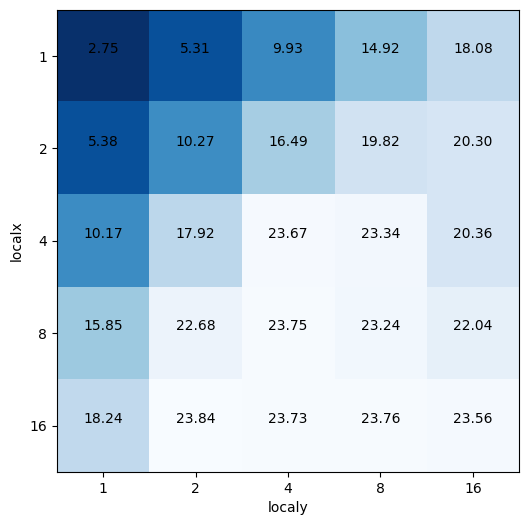

In [ ]:
r = grid_run(test, localx=[1,2,4,8,16], localy=[1,2,4,8,16])
grid_show(r, colorfun=lambda x: -x)

## Test 5: 169 FMAs per invocation (3 vec4 loads with overlap + 1 vec4 store)

In [ ]:
def test(wh=None, w=1024, h=1024, localsz=None, localx=1, localy=1, unrollx=1, unrolly=1, membw=False):
    global intex, outtex, source
    if wh is not None:
        w,h = wh,wh
    if localsz is not None:
        localx, localy = localsz
    src = np.stack([np.stack([np.full(w+2, 1, dtype=np.uint8)]*4, axis=-1)]*h).astype(np.float32)
    intex = createTexture(w+2, h, fmt=gl.GL_RGBA32F, output=False, src=src)
    outtex = createTexture(w, h, texid=1, fmt=gl.GL_RGBA32F)
    source = f"""
    #version 310 es
    precision mediump float;

    layout(local_size_x = {localx}, local_size_y = {localy}) in;
    layout(rgba32f, binding = 0) uniform mediump readonly image2D img_input;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;

    void main() {{
      ivec2 start_coords = ivec2(gl_GlobalInvocationID.xy) * ivec2(1,{unrolly});
      highp vec4 x, y, z;
      x = imageLoad(img_input, start_coords + ivec2(0,0));
      y = imageLoad(img_input, start_coords + ivec2(1,0));
      z = imageLoad(img_input, start_coords + ivec2(2,0));
      highp vec4 r0 = vec4(
          dot(x.xyzw, y.xyzw),
          dot(x.xyzw, y.yxwz),
          dot(x.xyzw, y.zwxy),
          dot(x.xyzw, y.wzyx)
      );
      highp vec4 r1 = vec4(
          dot(x.xyzw, z.xyzw),
          dot(x.xyzw, z.yxwz),
          dot(x.xyzw, z.zwxy),
          dot(x.xyzw, z.wzyx)
      );
      highp vec4 r2 = vec4(
          dot(y.xyzw, z.xyzw),
          dot(y.xyzw, z.yxwz),
          dot(y.xyzw, z.zwxy),
          dot(y.xyzw, z.wzyx)
      );
      highp vec4 r3 = vec4(
          dot(r0.xyzw, z.xyzw) / 4.,
          dot(r0.xyzw, z.yxwz) / 4.,
          dot(r0.xyzw, z.zwxy) / 4.,
          dot(r0.xyzw, z.wzyx) / 4.
      );
      highp vec4 s0 = vec4(
          dot(x.xyzw, x.xyzw),
          dot(x.xyzw, x.yxwz),
          dot(x.xyzw, x.zwxy),
          dot(x.xyzw, x.wzyx)
      );
      highp vec4 s1 = vec4(
          dot(y.xyzw, y.xyzw),
          dot(y.xyzw, y.yxwz),
          dot(y.xyzw, y.zwxy),
          dot(y.xyzw, y.wzyx)
      );
      highp vec4 s2 = vec4(
          dot(z.xyzw, z.xyzw),
          dot(z.xyzw, z.yxwz),
          dot(z.xyzw, z.zwxy),
          dot(z.xyzw, z.wzyx)
      );
      highp vec4 c0 = vec4(
          dot(s0.xyzw, x.xyzw) / 4.,
          dot(s0.xyzw, x.yxwz) / 4.,
          dot(s0.xyzw, x.zwxy) / 4.,
          dot(s0.xyzw, x.wzyx) / 4.
      );
      highp vec4 s0y = vec4(
          dot(s0.xyzw, y.xyzw) / 4.,
          dot(s0.xyzw, y.yxwz) / 4.,
          dot(s0.xyzw, y.zwxy) / 4.,
          dot(s0.xyzw, y.wzyx) / 4.
      );
      highp vec4 s0z = vec4(
          dot(s0.xyzw, z.xyzw) / 4.,
          dot(s0.xyzw, z.yxwz) / 4.,
          dot(s0.xyzw, z.zwxy) / 4.,
          dot(s0.xyzw, z.wzyx) / 4.
      );
      highp vec4 c1 = vec4(
          dot(s1.xyzw, y.xyzw) / 4.,
          dot(s1.xyzw, y.yxwz) / 4.,
          dot(s1.xyzw, y.zwxy) / 4.,
          dot(s1.xyzw, y.wzyx) / 4.
      );
      highp vec4 s1x = vec4(
          dot(s1.xyzw, x.xyzw) / 4.,
          dot(s1.xyzw, x.yxwz) / 4.,
          dot(s1.xyzw, x.zwxy) / 4.,
          dot(s1.xyzw, x.wzyx) / 4.
      );
      highp vec4 s1z = vec4(
          dot(s1.xyzw, z.xyzw) / 4.,
          dot(s1.xyzw, z.yxwz) / 4.,
          dot(s1.xyzw, z.zwxy) / 4.,
          dot(s1.xyzw, z.wzyx) / 4.
      );
      highp vec4 c2 = vec4(
          dot(s2.xyzw, z.xyzw) / 4.,
          dot(s2.xyzw, z.yxwz) / 4.,
          dot(s2.xyzw, z.zwxy) / 4.,
          dot(s2.xyzw, z.wzyx) / 4.
      );
      highp vec4 s2x = vec4(
          dot(s2.xyzw, x.xyzw) / 4.,
          dot(s2.xyzw, x.yxwz) / 4.,
          dot(s2.xyzw, x.zwxy) / 4.,
          dot(s2.xyzw, x.wzyx) / 4.
      );
      highp vec4 s2y = vec4(
          dot(s2.xyzw, y.xyzw) / 4.,
          dot(s2.xyzw, y.yxwz) / 4.,
          dot(s2.xyzw, y.zwxy) / 4.,
          dot(s2.xyzw, y.wzyx) / 4.
      );
      r0.x += 5.; // optimizer correction
      imageStore(img_output, ivec2(gl_GlobalInvocationID.xy),
          r0 + r1 + r2 + r3 + s0 + s1 + s2 + c0 + c1 + c2 + 
          s0y+ s0z+ s1x+ s1z+ s2x+ s2y);
    }}
    """
    computeShader(source)
    start = time.perf_counter()
    for i in range(50):
        gl.glDispatchCompute(w//localx, h//unrolly//localy, 1)
        # make sure writing to image has finished before read
        gl.glMemoryBarrier(gl.GL_SHADER_IMAGE_ACCESS_BARRIER_BIT)
    gl.glFinish()
    elapsed = (time.perf_counter() - start)/50
    output = downloadTextureFloat(outtex, w, h)
#     assert(output[0,0,0] == reps * 4 * 4)
    MACs = output.sum()
#     print(wh, unrollx, elapsed)
#     print(MACs, elapsed, 4*w*h*4*4)

    if membw:
        print(output[0,0].sum())
        return MACs / elapsed / 1e9, 4*w*h*4*4 / elapsed / 1024 / 1024
    else:
        return MACs / elapsed / 1e9

# test(localsz=(1,1), unrollx=4, unrolly=4)
test()
test()
gflops = test(localx=4, localy=8, membw=True)
print(source)
print(gflops)
showLastShaderDisassembly()

261.0

    #version 310 es
    precision mediump float;

    layout(local_size_x = 4, local_size_y = 8) in;
    layout(rgba32f, binding = 0) uniform mediump readonly image2D img_input;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;

    void main() {
      ivec2 start_coords = ivec2(gl_GlobalInvocationID.xy) * ivec2(1,1);
      highp vec4 x, y, z;
      x = imageLoad(img_input, start_coords + ivec2(0,0));
      y = imageLoad(img_input, start_coords + ivec2(1,0));
      z = imageLoad(img_input, start_coords + ivec2(2,0));
      highp vec4 r0 = vec4(
          dot(x.xyzw, y.xyzw),
          dot(x.xyzw, y.yxwz),
          dot(x.xyzw, y.zwxy),
          dot(x.xyzw, y.wzyx)
      );
      highp vec4 r1 = vec4(
          dot(x.xyzw, z.xyzw),
          dot(x.xyzw, z.yxwz),
          dot(x.xyzw, z.zwxy),
          dot(x.xyzw, z.wzyx)
      );
      highp vec4 r2 = vec4(
          dot(y.xyzw, z.xyzw),
          dot(y.xyzw, z.yxwz),
          dot(y.xyzw, z.zwxy),


de: dump command stream to file pandecode.dump.0348
pandecode: dump command stream to file pandecode.dump.0349
pandecode: dump command stream to file pandecode.dump.0350
pandecode: dump command stream to file pandecode.dump.0351
pandecode: dump command stream to file pandecode.dump.0352
pandecode: dump command stream to file pandecode.dump.0353
pandecode: dump command stream to file pandecode.dump.0354
pandecode: dump command stream to file pandecode.dump.0355
pandecode: dump command stream to file pandecode.dump.0356
pandecode: dump command stream to file pandecode.dump.0357
pandecode: dump command stream to file pandecode.dump.0358
pandecode: dump command stream to file pandecode.dump.0359
pandecode: dump command stream to file pandecode.dump.0360
pandecode: dump command stream to file pandecode.dump.0361
pandecode: dump command stream to file pandecode.dump.0362
pandecode: dump command stream to file pandecode.dump.0363
pandecode: dump command stream to file pandecode.dump.0364
pand

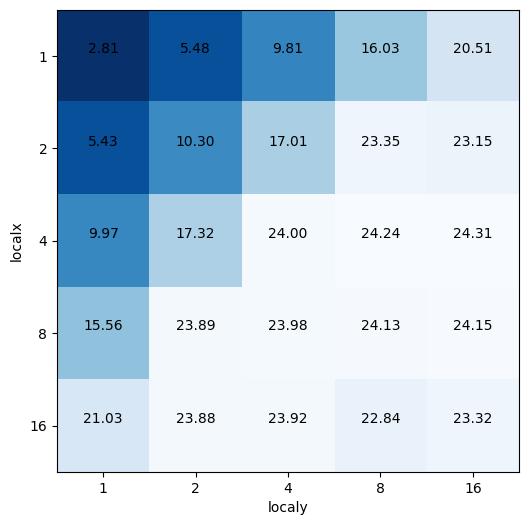

In [ ]:
r = grid_run(test, localx=[1,2,4,8,16], localy=[1,2,4,8,16])
grid_show(r, colorfun=lambda x: -x)

## Test 6: Julia fractal

In [ ]:
wh = 256
def test(wh=wh, localx=1, localy=1, membw=False):
    global intex, outtex, source
    w,h = wh,wh
    if localx * localy > 256: return float('nan')
    outtex = createTexture(w, h, texid=1, fmt=gl.GL_RGBA32F)
    source = f"""
    #version 310 es
    precision highp float;

    layout(local_size_x = {localx}, local_size_y = {localy}) in;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;
    layout(location = 2) uniform int iterations;

    void main() {{
      vec2 p = (vec2(gl_GlobalInvocationID.xy) / vec2({w}.,{h}.) - vec2(0.5)) * vec2(3.);
      int r = 0;

      for(int i = 0; i < iterations; i++) {{
        if(dot(p, p) < 10.) {{
          r++;
        }}
        p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
      }} 
      
      float n = float(r) / float(iterations) * 4.;
      
      imageStore(img_output, ivec2(gl_GlobalInvocationID.xy),
              vec4(0.5-cos(n*75.0)/2.0,0.5-cos(n* 120.0)/2.0,0.5-cos(n*165.0)/2.0,1.0));
    }}
    """
    if membw:
        print("\n".join([f"{n+1: 5d}  {line}" for n, line in enumerate(source.split('\n'))]))
    computeShader(source)
    ITERS = 1000
    gl.glUniform1i(2, ITERS)
    start = time.perf_counter()
    for i in range(50):
        gl.glDispatchCompute(w//localx, h//localy, 1)
        # make sure writing to image has finished before read
        gl.glMemoryBarrier(gl.GL_SHADER_IMAGE_ACCESS_BARRIER_BIT)
    gl.glFinish()
    elapsed = (time.perf_counter() - start)/50
    MACs = 13*ITERS*w*h

    if membw:
        print(f"{MACs / elapsed / 1e9:.2f} GFLOPS   {w*h*4*4 / elapsed / 1024 / 1024:.2f} MB/s  {elapsed * 1e3:.2f} ms")
    
    return MACs / elapsed / 1e9

test()
gflops = test(localx=16, localy=16, membw=True)
showLastShaderDisassembly()

    1  
    2      #version 310 es
    3      precision highp float;
    4  
    5      layout(local_size_x = 16, local_size_y = 16) in;
    6      layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;
    7      layout(location = 2) uniform int iterations;
    8  
    9      void main() {
   10        vec2 p = (vec2(gl_GlobalInvocationID.xy) / vec2(256.,256.) - vec2(0.5)) * vec2(3.);
   11        int r = 0;
   12  
   13        for(int i = 0; i < iterations; i++) {
   14          if(dot(p, p) < 10.) {
   15            r++;
   16          }
   17          p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
   18        } 
   19        
   20        float n = float(r) / float(iterations) * 4.;
   21        
   22        imageStore(img_output, ivec2(gl_GlobalInvocationID.xy),
   23                vec4(0.5-cos(n*75.0)/2.0,0.5-cos(n* 120.0)/2.0,0.5-cos(n*165.0)/2.0,1.0));
   24      }
   25      
37.42 GFLOPS   43.92 MB/s  22.77 ms
FMAs: 57.69% (30 / 52)

clause_0:
ds(0)

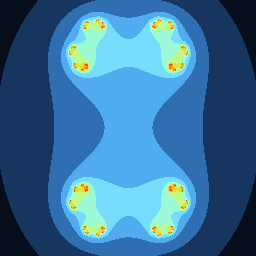

In [ ]:
downloadTexture(outtex, 256, 256)

command stream to file pandecode.dump.0208
pandecode: dump command stream to file pandecode.dump.0209
pandecode: dump command stream to file pandecode.dump.0210
pandecode: dump command stream to file pandecode.dump.0211
pandecode: dump command stream to file pandecode.dump.0212
pandecode: dump command stream to file pandecode.dump.0213
pandecode: dump command stream to file pandecode.dump.0214
pandecode: dump command stream to file pandecode.dump.0215
pandecode: dump command stream to file pandecode.dump.0216
pandecode: dump command stream to file pandecode.dump.0217
pandecode: dump command stream to file pandecode.dump.0218
pandecode: dump command stream to file pandecode.dump.0219
pandecode: dump command stream to file pandecode.dump.0220
pandecode: dump command stream to file pandecode.dump.0221
pandecode: dump command stream to file pandecode.dump.0222
pandecode: dump command stream to file pandecode.dump.0223
pandecode: dump command stream to file pandecode.dump.0224
pandecode: du

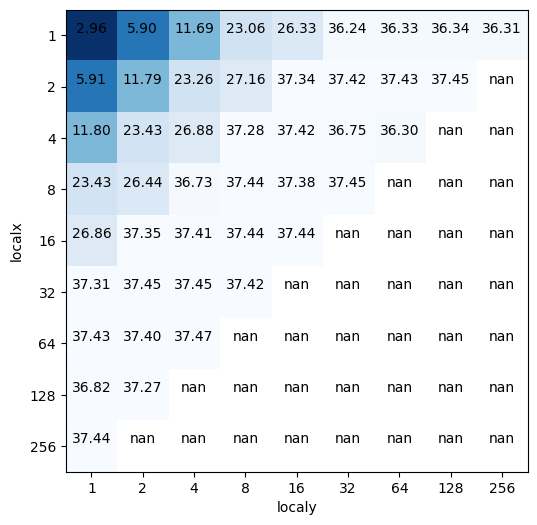

In [ ]:
r = grid_run(test, localx=[1,2,4,8,16,32,64,128,256], localy=[1,2,4,8,16,32,64,128,256])
grid_show(r, colorfun=lambda x: -np.log(x))

## Test 7: Julia fractal (4-way unroll)

In [ ]:
wh = 256
def test(wh=wh, localx=1, localy=1, membw=False):
    global intex, outtex, source
    w,h = wh,wh
    if localx * localy > 256: return float('nan')
    outtex = createTexture(w, h, texid=1, fmt=gl.GL_RGBA32F)
    source = f"""
    #version 310 es
    precision highp float;

    layout(local_size_x = {localx}, local_size_y = {localy}) in;
    layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;
    layout(location = 2) uniform int iterations;

    void main() {{
      vec2 p = (vec2(gl_GlobalInvocationID.xy) / vec2({w}.,{h}.) - vec2(0.5)) * vec2(3.);
      int r = 0;

      for(int i = 0; i < iterations / 4; i++) {{
        if(dot(p, p) < 10.) {{
          r++;
        }}
        p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
        if(dot(p, p) < 10.) {{
          r++;
        }}
        p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
        if(dot(p, p) < 10.) {{
          r++;
        }}
        p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
        if(dot(p, p) < 10.) {{
          r++;
        }}
        p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
      }} 
      
      float n = float(r) / float(iterations) * 4.;
      
      imageStore(img_output, ivec2(gl_GlobalInvocationID.xy),
              vec4(0.5-cos(n*75.0)/2.0,0.5-cos(n* 120.0)/2.0,0.5-cos(n*165.0)/2.0,1.0));
    }}
    """
    if membw:
        print("\n".join([f"{n+1: 5d}  {line}" for n, line in enumerate(source.split('\n'))]))
    computeShader(source)
    ITERS = 1000
    gl.glUniform1i(2, ITERS)
    start = time.perf_counter()
    for i in range(50):
        gl.glDispatchCompute(w//localx, h//localy, 1)
        # make sure writing to image has finished before read
        gl.glMemoryBarrier(gl.GL_SHADER_IMAGE_ACCESS_BARRIER_BIT)
    gl.glFinish()
    elapsed = (time.perf_counter() - start)/50
    output = downloadTextureFloat(outtex, w, h)
    MACs = 32*ITERS/4*w*h

    if membw:
        print(f"{MACs / elapsed / 1e9:.2f} GFLOPS   {w*h*4*4 / elapsed / 1024 / 1024:.2f} MB/s  {elapsed * 1e3:.2f} ms")
    
    return MACs / elapsed / 1e9

test()
gflops = test(localx=16, localy=16, membw=True)
showLastShaderDisassembly()

    1  
    2      #version 310 es
    3      precision highp float;
    4  
    5      layout(local_size_x = 16, local_size_y = 16) in;
    6      layout(rgba32f, binding = 1) uniform mediump writeonly image2D img_output;
    7      layout(location = 2) uniform int iterations;
    8  
    9      void main() {
   10        vec2 p = (vec2(gl_GlobalInvocationID.xy) / vec2(256.,256.) - vec2(0.5)) * vec2(3.);
   11        int r = 0;
   12  
   13        for(int i = 0; i < iterations / 4; i++) {
   14          if(dot(p, p) < 10.) {
   15            r++;
   16          }
   17          p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
   18          if(dot(p, p) < 10.) {
   19            r++;
   20          }
   21          p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
   22          if(dot(p, p) < 10.) {
   23            r++;
   24          }
   25          p = vec2(p.x*p.x - p.y*p.y + 0.7885, 2.*p.x*p.y);
   26          if(dot(p, p) < 10.) {
   27            r++;
   28          }
   29

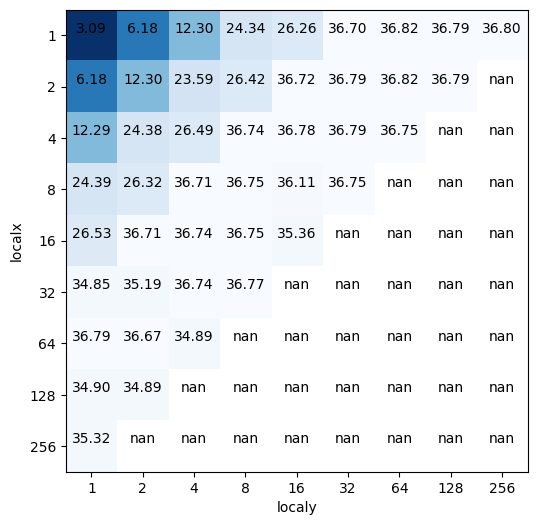

In [ ]:
r = grid_run(test, localx=[1,2,4,8,16,32,64,128,256], localy=[1,2,4,8,16,32,64,128,256])
grid_show(r, colorfun=lambda x: -np.log(x))